In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def fetch_stcrdb_angles(pdb_id):
    url = f"https://opig.stats.ox.ac.uk/webapps/stcrdab-stcrpred/StrViewer?pdb={pdb_id.lower()}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"❌ Failed to fetch {pdb_id}: HTTP {response.status_code}")
            return None
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the angle table by scanning all tables and looking for known headers
        tables = soup.find_all('table')
        angle_table = None
        for table in tables:
            headers = [th.text.strip() for th in table.find_all('th')]
            if headers == ["Angle", "Value"]:
                angle_table = table
                break

        if angle_table is None:
            print(f"⚠️ No angle table found for {pdb_id}")
            return None

        result = {'PDB': pdb_id.upper()}
        for row in angle_table.find_all('tr')[1:]:
            cells = row.find_all('td')
            angle = cells[0].text.strip()
            value = cells[1].text.strip().replace('°', '').replace('Å', '')
            result[angle] = float(value)
        return result

    except Exception as e:
        print(f"❌ Error fetching {pdb_id}: {e}")
        return None

# --- Load your result CSV ---
my_results = pd.read_csv("/workspaces/Graphormer/TRangle/trangle/angles_results.csv")  # Ensure this has a 'PDB' column
pdb_ids = my_results['PDB'].unique()

# --- Fetch STCRdb values ---
all_data = []
for pdb_id in pdb_ids:
    print(f"📡 Fetching STCRdb angles for {pdb_id}...")
    result = fetch_stcrdb_angles(pdb_id)
    if result:
        print(result)
        all_data.append(result)
    time.sleep(1.5)  # Be nice to their server

# --- Save results ---
stcrdb_df = pd.DataFrame(all_data)
stcrdb_df.to_csv("stcrdb_results.csv", index=False)
print("✅ Saved STCRdb results to stcrdb_results.csv")


📡 Fetching STCRdb angles for 5wkf...
📡 Fetching STCRdb angles for 6vrm...
📡 Fetching STCRdb angles for 8es9...
📡 Fetching STCRdb angles for 3o8x...
📡 Fetching STCRdb angles for 6vm7...
📡 Fetching STCRdb angles for 6mra...
📡 Fetching STCRdb angles for 5tez...
📡 Fetching STCRdb angles for 8wul...
📡 Fetching STCRdb angles for 6vma...
📡 Fetching STCRdb angles for 2cdf...
📡 Fetching STCRdb angles for 7s8j...
📡 Fetching STCRdb angles for 4udt...
📡 Fetching STCRdb angles for 6at6...
📡 Fetching STCRdb angles for 3vwk...
📡 Fetching STCRdb angles for 3kps...
📡 Fetching STCRdb angles for 4ms8...
📡 Fetching STCRdb angles for 5ks9...
📡 Fetching STCRdb angles for 6v18...
📡 Fetching STCRdb angles for 8eo8...
📡 Fetching STCRdb angles for 2vlj...
📡 Fetching STCRdb angles for 6amu...
📡 Fetching STCRdb angles for 4ozf...
📡 Fetching STCRdb angles for 7rtr...
📡 Fetching STCRdb angles for 5eu6...
📡 Fetching STCRdb angles for 4apq...
📡 Fetching STCRdb angles for 4z7u...
📡 Fetching STCRdb angles for 2nw2...
📡

    PDB          BA         BC1        AC1        BC2         AC2         dc
0  5WKF  122.895819  109.201129  64.549507  25.529648  154.528876  15.216458
1  6VRM  120.259191  105.116468  63.855720  21.434969  153.241427  15.467328
2  8ES9  116.426950  112.403362  77.820281  22.564151  166.787083  15.786679
3  3O8X  123.708906  125.456094  78.018921  36.934846  164.366518  16.378778
4  6VM7  129.469864  121.696827  69.432547  37.206878  156.372225  15.671114
    PDB     BC2    BC1     BA    AC2     AC1     dc  Docking angle
0  5WKF  105.05  74.18 -55.82  79.79  123.90  15.76          39.59
1  6VRM  103.62  72.56 -58.21  82.07  124.91  17.13          51.43
2  8ES9   99.43  67.31 -47.86  87.02  128.97  18.02          84.86
3  3O8X   99.50  78.12 -58.88  79.42  123.34  16.23          24.93
4  6VM7  102.44  70.11 -57.96  73.60  124.55  17.41            NaN
Merged dataframe has 64 entries.


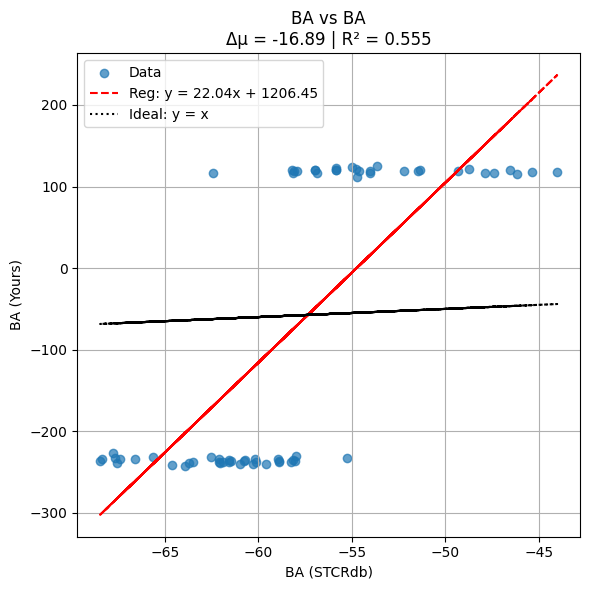

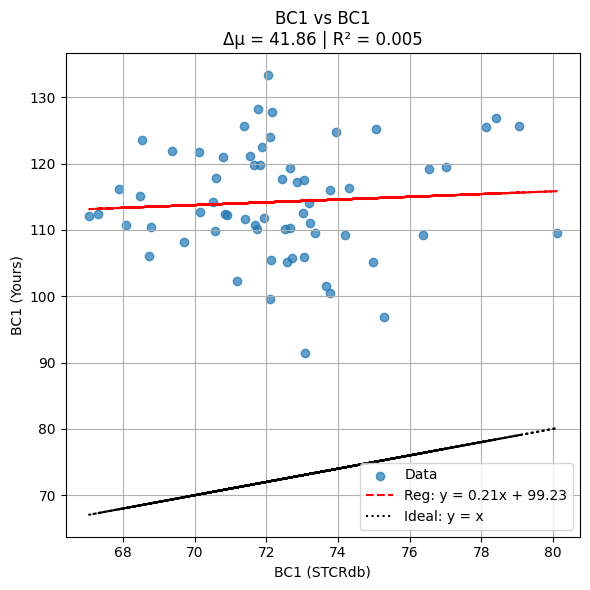

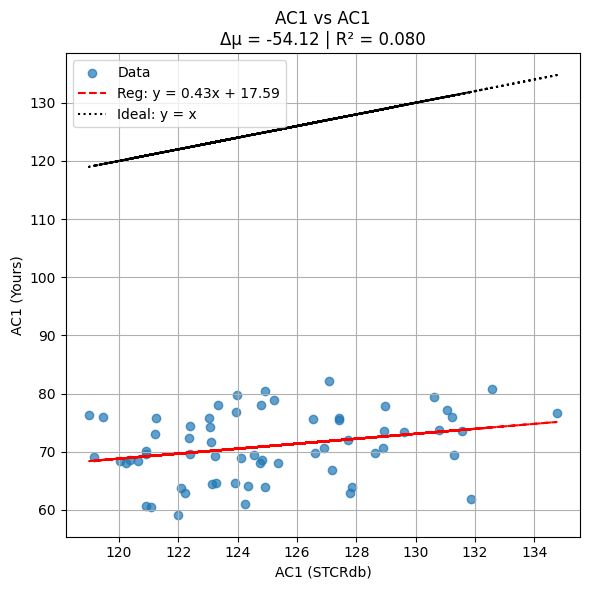

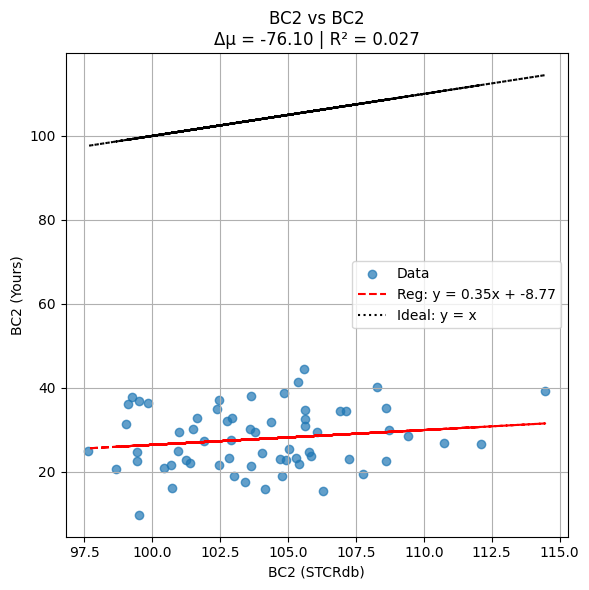

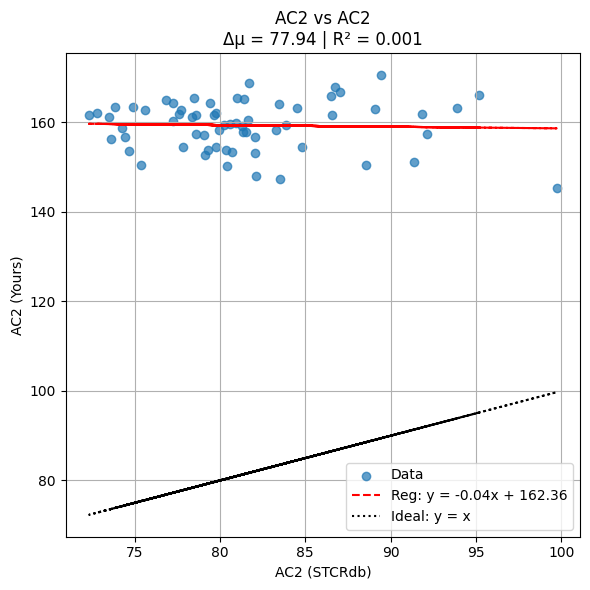

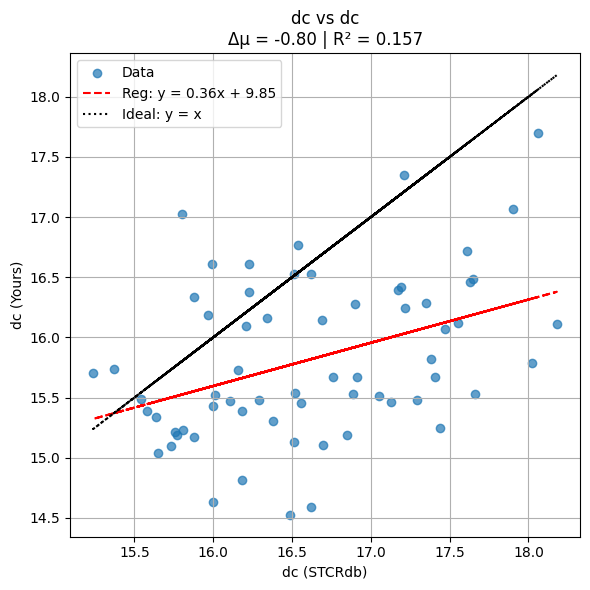

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# ----------------------------
# Configuration
# ----------------------------
mine_csv = "/workspaces/Graphormer/TRangle/trangle/outputs/angles_results.csv"
stcr_csv = "stcrdb_results.csv"

# Mapping between your CSV columns and STCRdb CSV columns
# If the STCRdb file uses same column names, you can map directly
angle_map = {
    "BA": "BA",
    "BC1": "BC1",
    "AC1": "AC1",
    "BC2": "BC2",
    "AC2": "AC2",
    "dc": "dc",
}

# ----------------------------
# Load and merge
# ----------------------------
mine = pd.read_csv(mine_csv)   # must have a PDB column and the 6 values
stcr = pd.read_csv(stcr_csv)

# Ensure both have 'PDB' column with uppercase for matching
mine["PDB"] = mine["PDB"].str.replace("_fv", "").str.upper()
stcr["PDB"] = stcr["PDB"].str.upper()
print(mine.head())
print(stcr.head())

# Merge on PDB
df = pd.merge(mine, stcr, on="PDB", suffixes=("_mine", "_stcr"))

print(f"Merged dataframe has {len(df)} entries.")

# ----------------------------
# Plot comparisons
# ----------------------------
for angle_name, stcr_col in angle_map.items():
    my_col = f"{angle_name}_mine"
    their_col = f"{stcr_col}_stcr"

    if my_col not in df.columns or their_col not in df.columns:
        print(f"⚠️ Missing columns for {angle_name}, skipping.")
        continue

    x = df[their_col].values
    y = df[my_col].values

    # Correct for angle wrap-around (only for angular measures)
    if angle_name.lower() != "dc":
        # bring angle differences into [-180,180]
        y_corrected = x + ((y - x + 180) % 360 - 180)
    else:
        y_corrected = y

    # Linear regression
    slope, intercept, r_value, p_value, stderr = linregress(x, y_corrected)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y_corrected, alpha=0.7, label="Data")
    plt.plot(x, slope * x + intercept, 'r--', label=f'Reg: y = {slope:.2f}x + {intercept:.2f}')
    plt.plot(x, x, 'k:', label='Ideal: y = x')

    plt.xlabel(f"{stcr_col} (STCRdb)")
    plt.ylabel(f"{angle_name} (Yours)")
    mean_diff = np.mean(y_corrected - x)
    plt.title(f"{angle_name} vs {stcr_col}\nΔμ = {mean_diff:.2f} | R² = {r_value**2:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


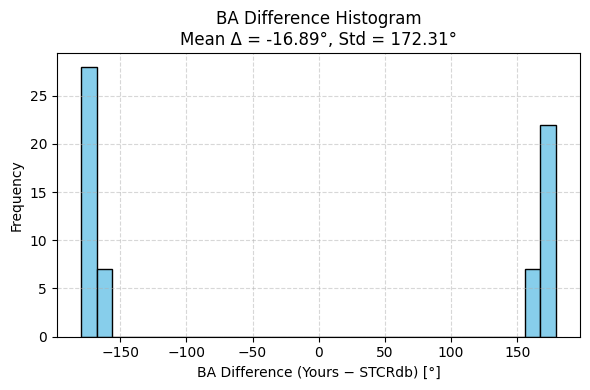

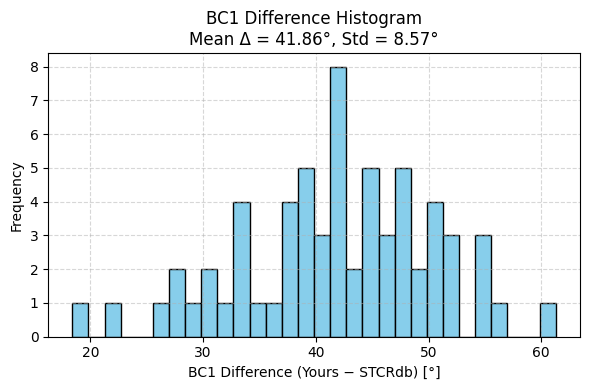

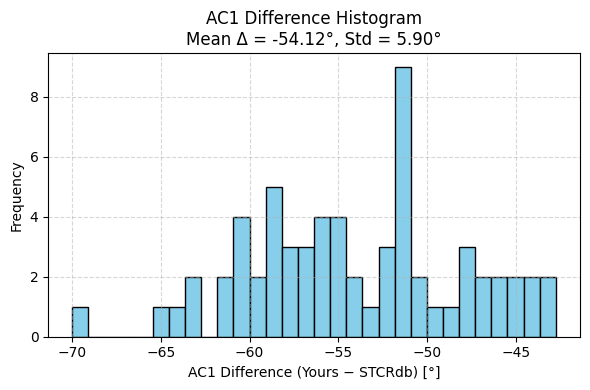

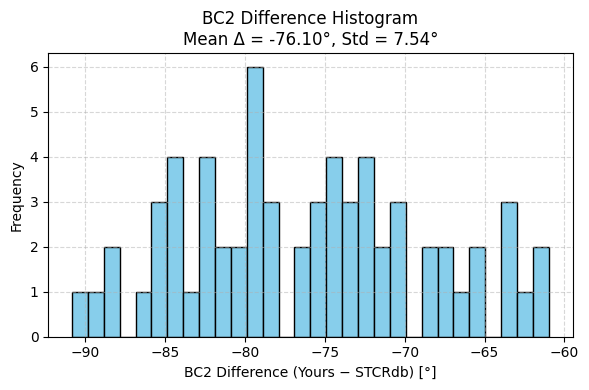

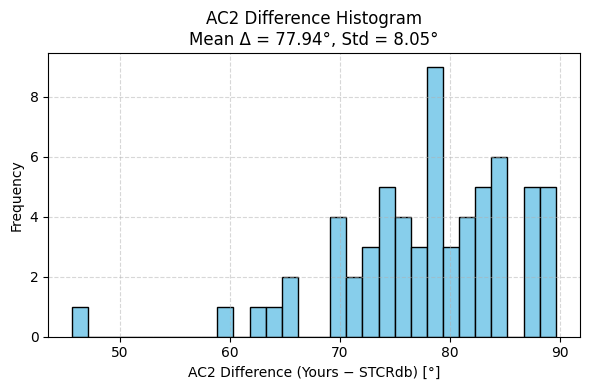

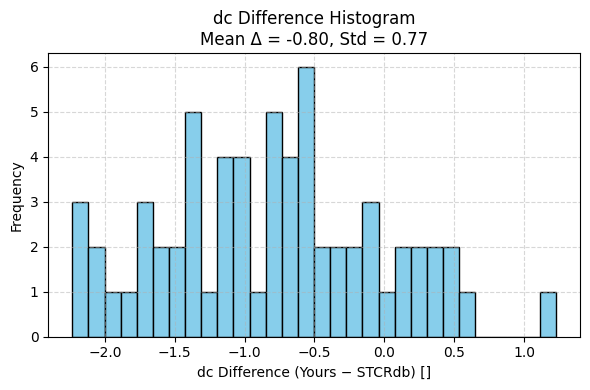

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through angle map
for angle_name, stcr_col in angle_map.items():
    my_col = f"{angle_name}_mine"
    their_col = f"{stcr_col}_stcr"

    if my_col not in df.columns or their_col not in df.columns:
        print(f"⚠️ Missing columns for {angle_name}, skipping.")
        continue

    x = df[their_col].values
    y = df[my_col].values

    # Only apply wrap-around for angular measures
    if angle_name.lower() != "dc":
        angle_diff = (y - x + 180) % 360 - 180
        unit = "°"
    else:
        angle_diff = y - x
        unit = ""  # no unit for distance

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(angle_diff, bins=30, color='skyblue', edgecolor='black')
    plt.title(
        f"{angle_name} Difference Histogram\n"
        f"Mean Δ = {angle_diff.mean():.2f}{unit}, Std = {angle_diff.std():.2f}{unit}"
    )
    plt.xlabel(f"{angle_name} Difference (Yours − STCRdb) [{unit}]")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()



     PDB          HL         HC1        LC1        HC2         LC2    dc_mine  \
0   5WKF  133.424902  111.479021  64.549537  26.729644  154.528905  15.216463   
1   6VRM  131.421757  112.832809  63.855750  31.143798  153.241456  15.467332   
2   8ES9  139.872717  126.659701  77.820303  38.171587  166.787100  15.786686   
3   3O8X  137.156668  120.163356  78.018945  33.185851  164.366540  16.378784   
4   6VM7  139.392355  119.089342  69.432574  35.058735  156.372252  15.671119   
..   ...         ...         ...        ...        ...         ...        ...   
59  4MAY  128.234846  118.589802  73.074032  30.648697  162.756578  15.485428   
60  7SG0  130.751766  114.959021  68.627485  28.349974  156.690972  15.468042   
61  4P2O  123.972826  115.381779  68.332404  31.691781  158.298616  15.038518   
62  6OVN  138.626273  111.364589  61.025624  30.395078  150.351642  14.633679   
63  6OVO  125.246306  104.507514  68.072903  18.550518  156.849001  15.534782   

       BC2    BC1     BA   

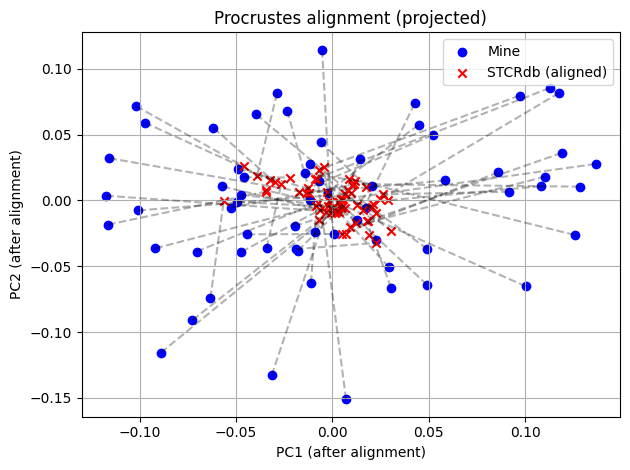

In [4]:
import pandas as pd
import numpy as np
from scipy.spatial import procrustes
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# === Load your values and STCRdb values ===
# Load your values and STCRdb values
mine = pd.read_csv("/workspaces/Graphormer/TRangle/trangle/angles_results.csv")  # has HL, HC1, LC1, HC2, LC2, dc
stcr = pd.read_csv("stcrdb_results.csv")  # has BA, BC1, AC1, BC2, AC2, dc

mine["PDB"] = mine["PDB"].str.upper()
stcr["PDB"] = stcr["PDB"].str.upper()
df = pd.merge(mine, stcr, on="PDB", suffixes=("_mine", "_stcr"))
print(df)
print(f"Merged entries: {len(df)}")

# Build matrices
mine_cols = ["HL", "HC1", "LC1", "HC2", "LC2", "dc_mine"]
stcr_cols = ["BC2", "BC1", "BA", "AC2", "AC1", "dc_stcr"]

X_mine = df[mine_cols].to_numpy()
X_stcr = df[stcr_cols].to_numpy()

# --- 1) Procrustes analysis (compares shapes after optimal translation/rotation/scale) ---
m1, m2, disparity = procrustes(X_mine, X_stcr)
print(f"Procrustes disparity: {disparity:.6f} (0 = identical)")

# --- 2) Pairwise distance correlation ---
dist_mine = squareform(pdist(X_mine))
dist_stcr = squareform(pdist(X_stcr))
corr, pval = spearmanr(dist_mine.flatten(), dist_stcr.flatten())
print(f"Pairwise distance Spearman correlation: {corr:.3f} (p={pval:.3e})")

# Optional: visualize the Procrustes alignment
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(m1[:,0], m1[:,1], label='Mine', c='blue')
plt.scatter(m2[:,0], m2[:,1], label='STCRdb (aligned)', c='red', marker='x')
for i in range(len(df)):
    plt.plot([m1[i,0], m2[i,0]], [m1[i,1], m2[i,1]], 'k--', alpha=0.3)
plt.xlabel('PC1 (after alignment)')
plt.ylabel('PC2 (after alignment)')
plt.title('Procrustes alignment (projected)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
